# Clustering-Based Skin Tone Estimation

Following the [official implementation](https://github.com/marinbenc/lesion_segmentation_bias/tree/main) of the method described in \[1\].

In [1]:
import cv2 as cv
import numpy as np
import kneed
import matplotlib.pyplot as plt

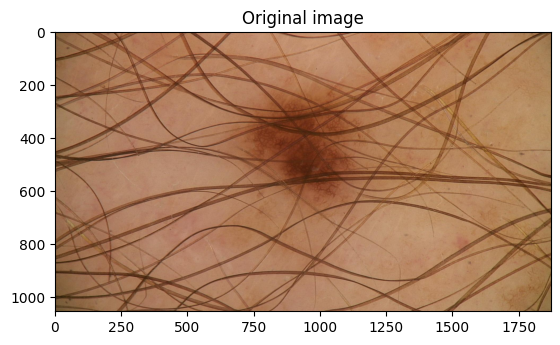

In [2]:
SAMPLE_IMAGE = "E:\\ISIC 2020\\train\\ISIC_5479774.jpg"

img = cv.imread(SAMPLE_IMAGE)
plt.title("Original image")
plt.imshow(img[:,:,::-1])

## Mask non-skin pixels
1. Apply CLAHE to the L* channel
2. Remove artifacts using Dullrazor \[2\]
3. Otsu thresholding of the value channel
4. Expand the resulting mask (morphology)

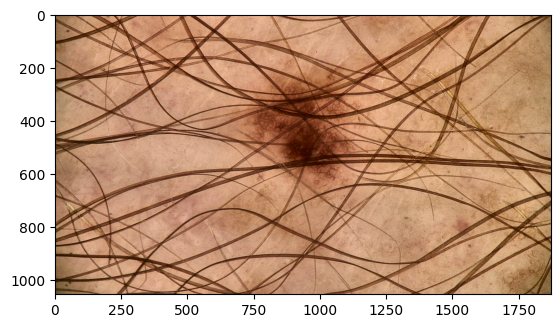

In [3]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)
lab_planes = list(cv.split(lab))
lab_planes[0] = clahe.apply(lab_planes[0])
lab = cv.merge(lab_planes)
clahe_img = cv.cvtColor(lab, cv.COLOR_LAB2BGR)

plt.imshow(clahe_img[:,:,::-1])

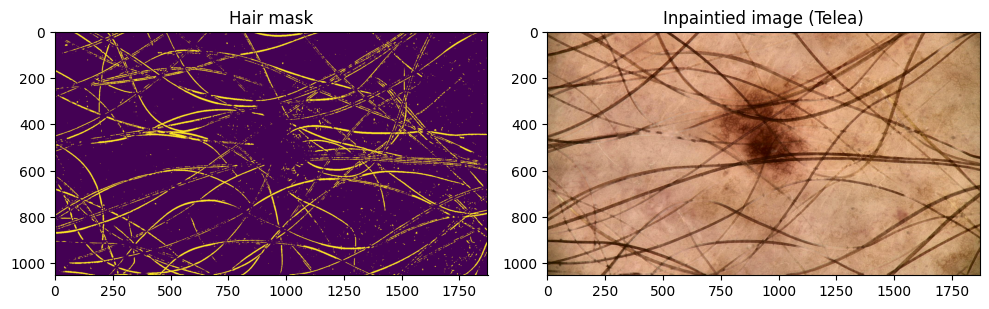

In [4]:
# Dullrazor
grayscale = cv.cvtColor(clahe_img, cv.COLOR_BGR2GRAY) # [1] uses RGB2GRAY
kernel = cv.getStructuringElement(1, (9,9)) # [1] uses a 3x3 kernel
blackhat = cv.morphologyEx(grayscale, cv.MORPH_BLACKHAT, kernel)
blurred = cv.GaussianBlur(blackhat, (3,3), cv.BORDER_DEFAULT)

_, hair_mask = cv.threshold(blurred, 20, 255, cv.THRESH_BINARY) # [2] sets the threshold at 10, [1] at 25
inpainted_img = cv.inpaint(clahe_img, hair_mask, 6, cv.INPAINT_TELEA)
masked_img = cv.bitwise_and(clahe_img, clahe_img, mask=255 - hair_mask)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Hair mask")
plt.imshow(hair_mask)
plt.subplot(1,2,2)
plt.title("Inpaintied image (Telea)")
plt.imshow(inpainted_img[:,:,::-1])
plt.tight_layout()

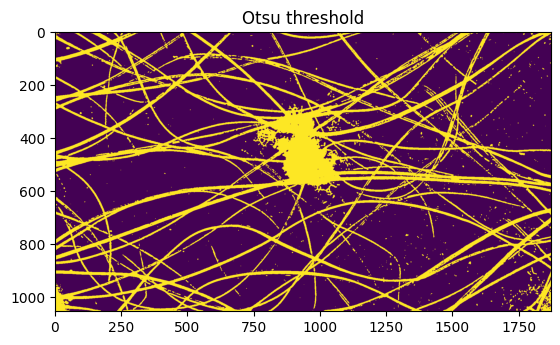

In [5]:
# threshold to remove pigmentations
hsv = cv.cvtColor(masked_img, cv.COLOR_BGR2HSV)
_, _, v = cv.split(hsv)
v = cv.GaussianBlur(v, (5, 5), 0)
_, v_thresh = cv.threshold(v, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
thresh = v_thresh

plt.title("Otsu threshold")
plt.imshow(thresh)

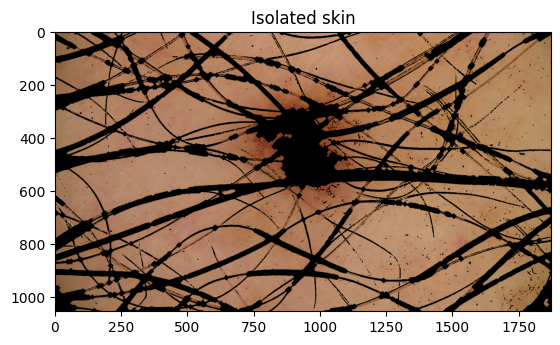

In [6]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=5)
thresh = cv.dilate(thresh, kernel, iterations=5)
thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel, iterations=5)

thresh = cv.bitwise_or(thresh, hair_mask)
final_image = cv.bitwise_and(img, img, mask=255 - thresh)

plt.title("Isolated skin")
plt.imshow(final_image[:,:,::-1])

## Clustering CIELAB pixel values

In [7]:
def kmeans_dominant_color_lab(processed_img, k):
  processed_img_lab = cv.cvtColor(processed_img, cv.COLOR_BGR2LAB)
  pixel_values = processed_img_lab.reshape((-1, 3))
  # remove black pixels
  pixel_values = pixel_values[np.where(pixel_values[:, 0] > 0)]
  # keep only a and b channels
  #pixel_values = pixel_values[:, 1:]
  pixel_values = np.float32(pixel_values)

  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
  compactness, labels, (centers) = cv.kmeans(pixel_values, k, None, criteria, 10, cv.KMEANS_PP_CENTERS)
  centers = np.uint8(centers)
  labels = labels.flatten()

  dominant_label = np.argmax(np.bincount(labels))
  dominant_color = centers[dominant_label]
  dominant_color = np.array(dominant_color)
  dominant_color = np.round(dominant_color).astype(int)
  # add back L channel
  dominant_color = cv.cvtColor(np.uint8([[dominant_color]]), cv.COLOR_LAB2RGB)
  return dominant_color, compactness

def get_ita_angle(color_rgb: np.ndarray) -> float:
  color_lab = cv.cvtColor(np.uint8([[color_rgb]]), cv.COLOR_RGB2LAB)[0][0]
  return np.arctan((color_lab[0] - 50) / color_lab[2]) * 180 / np.pi

In [8]:
ks = range(2, 10)
colors, compactnesses = zip(*[kmeans_dominant_color_lab(final_image, k) for k in ks])
kneedle = kneed.KneeLocator(ks, compactnesses, S=1.0, curve='convex', direction='decreasing')
dominant_color = colors[kneedle.elbow]
dominant_color

array([[[178, 132, 102]]], dtype=uint8)

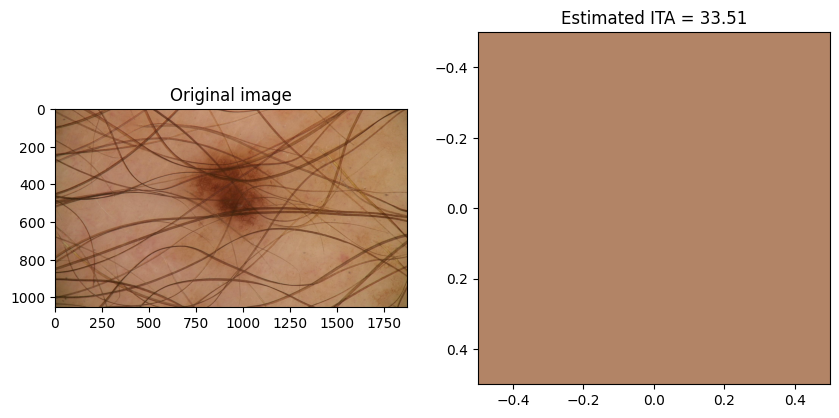

In [9]:
angle = get_ita_angle(dominant_color.squeeze())

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(img[:,:,::-1])
plt.subplot(1,2,2)
plt.title(f"Estimated ITA = {round(angle, 2)}")
plt.imshow(dominant_color)

## Bibliography

\[1\] Benčević M, Habijan M, Galić I, Babin D, Pižurica A. Understanding skin color bias in deep learning-based skin lesion segmentation. Comput Methods Programs Biomed. 2024 Mar